Source code for this post can be found here: [KernelLogisticRegression.py](https://github.com/Nicholas-Sliter/middlebury-csci-0451/blob/main/posts/kernel-logistic-regression/KernelLogisticRegression.py)

RE: my last post on [Logistic Regression](http://www.nsliter.com/middlebury-csci-0451/posts/logistic-regression-and-gradient-descent/), what happens if our data is very non-linear?

Consider the following example:



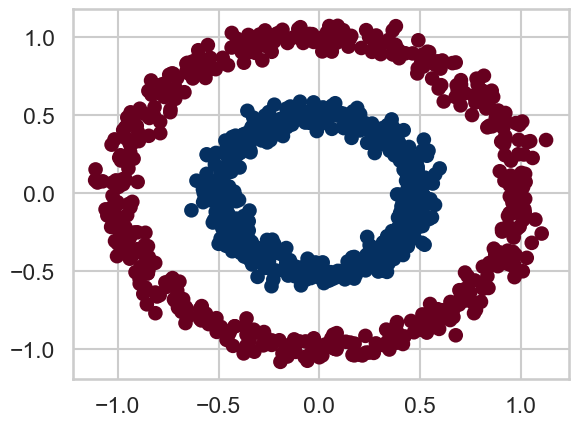

In [115]:
#| echo: false

from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=0)

g = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')

plt.show()

None

Obviously, a linear decision boundary in $\mathbb{R}^2$ will not work here. This motivates todays post on Kernel Logistic Regression.


In Kernel Logistic Regression, we use the kernel trick to transform our data into a higher dimensional space. Then we do classification in that high dimensional space. This is useful when we have data that is not linearly separable in the original space. We can use the kernel trick to transform our data into a higher dimensional space where it may be linearly separable.

The kernel is in essence a way for us to map our data to a higher dimensional space. Once that mapping has been done, the model is very similar to the logistic regression models we have seen before. 

## Empirical Risk

In Kernel Logistic Regression, we change how we make predictions. Instead of the familiar $w \cdot X$ we saw in logistic regression, we will be using a vector of kernel weights $v$ and a kernel matrix $K$. The kernel matrix is computed by applying the kernel function to the points in our training data.

Following this modification, we calculate the empirical risk of the model by computing the kernel matrix using the training data. We then use the kernel matrix to compute our predictions by multiplying our vector of kernel weights by the kernel matrix. We then compute the logistic loss between our predictions and the true labels. This gives us the empirical risk of the model.



```python
def __emphirical_risk(self, X_, y, v) -> float:
    km = self.kernel(self.X_train, X_, **self.kernel_kwargs)
    y_pred = v @ km
    return self.logistic_loss(y, y_pred)
```



In [2]:
#| echo: false
import numpy as np
np.seterr(all='ignore')
None

## Examples

Let's consider the following simple example using the `make_moons` dataset from `sklearn.datasets`.

In [19]:
#| code-fold: false

from KernelLogisticRegression import KernelLogisticRegression
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_moons

X, y = make_moons(100, shuffle = True, noise = 0.1)
KLR = KernelLogisticRegression(rbf_kernel, gamma = .1)
KLR.fit(X, y)
print(KLR.score(X, y))

0.99


In [113]:
#| echo: false
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

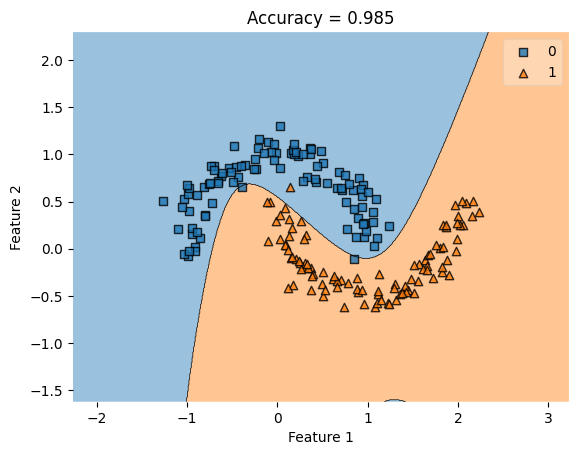

In [22]:
#| code-fold: false
X, y = make_moons(200, shuffle = True, noise = 0.1)
plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

Observe how the plotted decision boundary is non-linear but separates the data almost perfectly. Again, this is because the data was transformed into a higher dimensional space where our decision boundary is linear.


## Choosing Gamma

Consider the hyperparameter gamma. In essence, gamma controls how complex we allow our decision boundary to be. If gamma is too small, our decision boundary will be too simple. If gamma is too large, our decision boundary will be too complex. This is illustrated in the following example:

In [112]:
#| code-fold: false

X, y = make_moons(100, shuffle = True, noise = 0.15)
KLRG = KernelLogisticRegression(rbf_kernel, gamma = 200000)
KLRG.fit(X, y)
print(KLRG.score(X, y))

1.0


Wow! With $gamma = 200000$ we achieve perfect classification on the training data. This is because we have allowed our decision boundary to be very complex. But is this a good thing? 

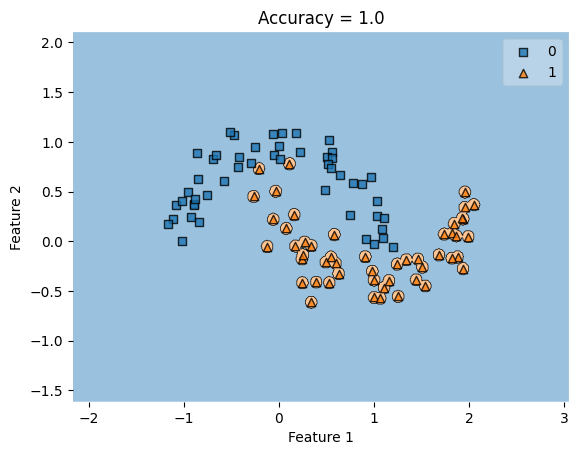

In [29]:
#| echo: false 
plot_decision_regions(X, y, clf = KLRG)
title = plt.gca().set(title = f"Accuracy = {KLRG.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

Observe how we have created small circles around our orange points. This decision boundary is too complex. It will not generalize.

Let's generate new data from the same distribution and see how our model performs on it.

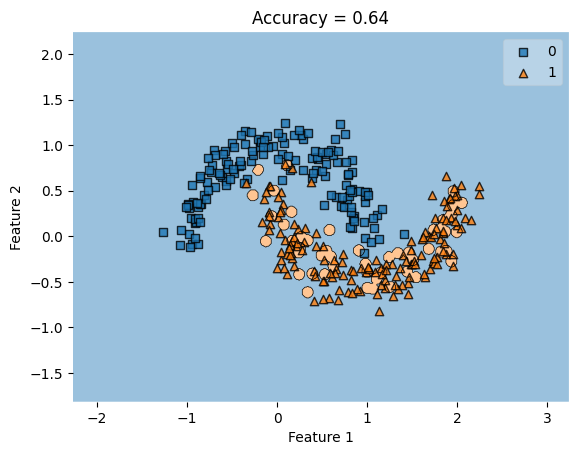

In [30]:
#| code-fold: false
X, y = make_moons(300, shuffle = True, noise = 0.15)
plot_decision_regions(X, y, clf = KLRG)
title = plt.gca().set(title = f"Accuracy = {KLRG.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

As you can see, our model does not generalize well. This is because our choice of gamma was too large and caused overfitting. Gamma must be chosen carefully.

## Vary the Noise

Now let's vary the noise in the data. We will examine how noise and gamma interact to affect the performance of our model.

In [110]:
#| code-fold: false

def gamma_noise_experiment(gamma_list, noise):
    res = []
    for gamma in gamma_list:
        X, y = make_moons(60, shuffle = True, noise = noise)
        KLR = KernelLogisticRegression(rbf_kernel, gamma = gamma)
        KLR.fit(X, y)
        X_test, y_test = make_moons(200, shuffle = True, noise = noise)
        res.append({
            "noise": noise,
            "gamma": gamma,
            "train_accuracy": KLR.score(X, y),
            "test_accuracy": KLR.score(X_test, y_test)
        })
    return res

In [91]:
#| code-fold: false
gamma_list = [0.0001, 0.001, 0.1, 0.2, 0.5, 1, 5, 10, 100]
noise_list = [0, 0.1, 0.2, 0.4, 0.8, 1]

In [92]:
columns = ["noise", "gamma", "train_accuracy", "test_accuracy"]
results = []

for noise in noise_list:
    res = gamma_noise_experiment(gamma_list, noise)
    results.append(res)

In [93]:
#| echo: false
#| output: false

import pandas as pd

df = pd.DataFrame([item for sublist in results for item in sublist], columns = columns) # I really hate pandas

,noise,gamma,train_accuracy,test_accuracy
0,0.0,0.0001,0.866667,0.880
1,0.0,0.0010,0.866667,0.880
2,0.0,0.1000,1.000000,1.000
3,0.0,0.2000,1.000000,1.000
4,0.0,0.5000,1.000000,1.000
5,0.0,1.0000,1.000000,1.000
6,0.0,5.0000,0.966667,0.965
7,0.0,10.0000,1.000000,1.000
8,0.0,100.0000,1.000000,1.000
9,0.1,0.0001,0.883333,0.885


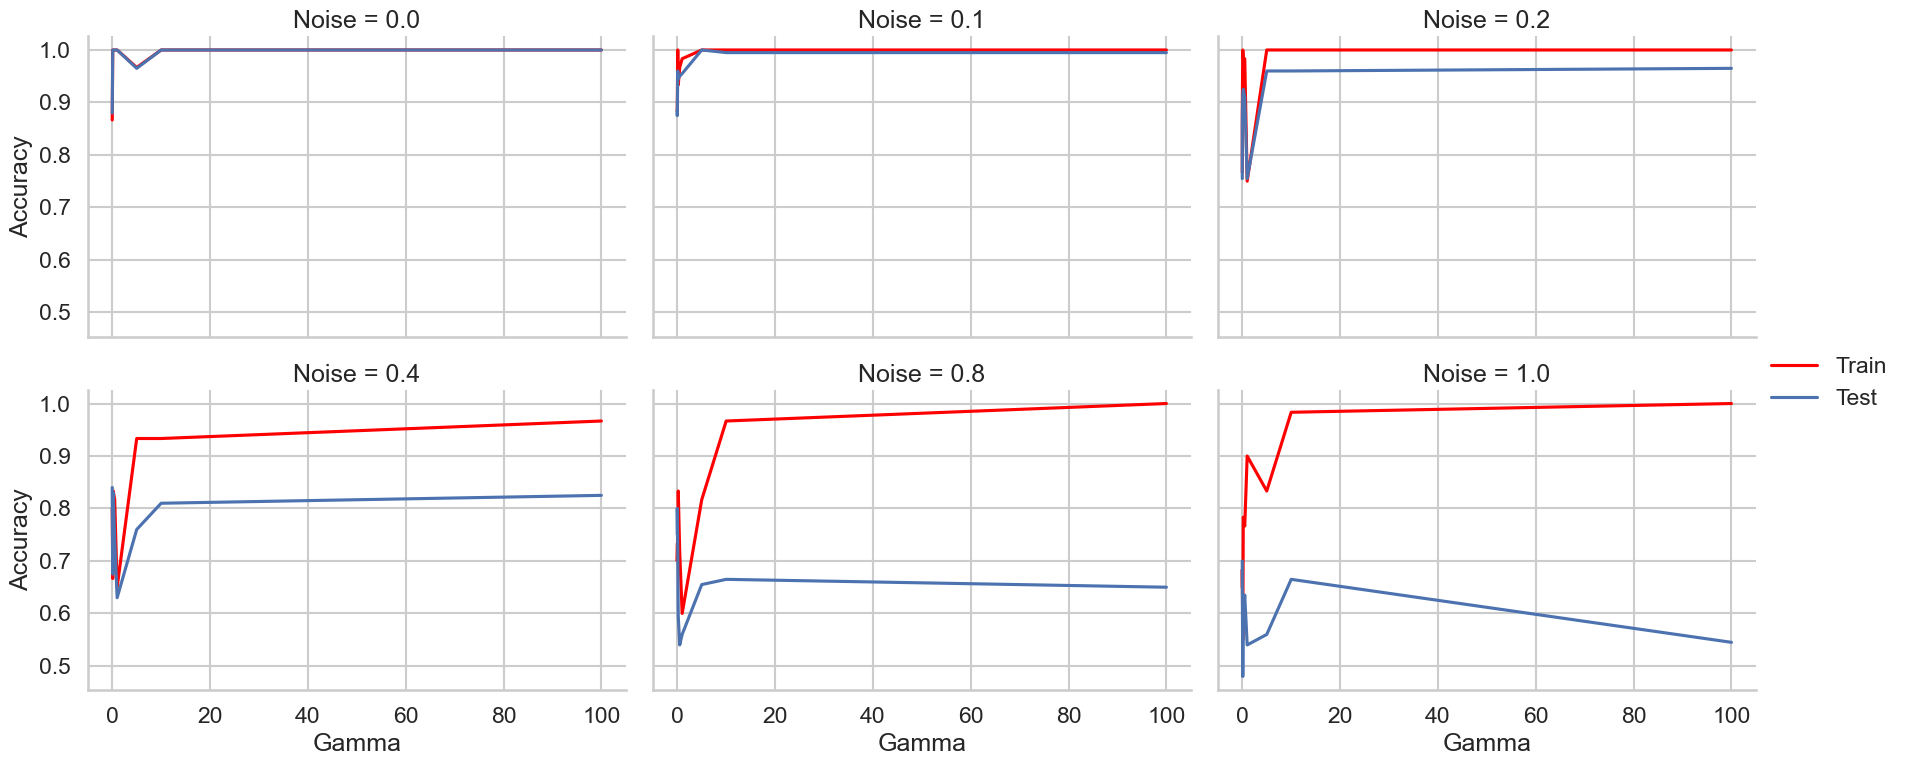

In [111]:
#| echo: false
#| output: true

# Plot df (noise vs accuracy (both train and test)) with different gamma values
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
sns.set(style = "whitegrid")
sns.set_context("talk")

g = sns.FacetGrid(df, col = "noise", col_wrap = 3, height = 4, aspect = 1.5)
g.map(sns.lineplot, "gamma", "train_accuracy", label = "Train", color = "red")
g.map(sns.lineplot, "gamma", "test_accuracy", label = "Test")
g.set_axis_labels("Gamma", "Accuracy")
g.set_titles("Noise = {col_name}")
g.add_legend()

None



Observe that as our noise increases, our train and test accuracy decrease. Observe also that as gamma increases our training accuracy approaches 100%. But clearly this causes overfit as we observe the test accuracy tends to decrease as gamma increases.

## Circles

Now let's circle back to our initial example and examine how our model performs on the `make_circles` dataset.

In [11]:
#| code-fold: false

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(200, shuffle = True, noise = 0.02, factor = 0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

KLR = KernelLogisticRegression(rbf_kernel, gamma = 1)
KLR.fit(X_train, y_train)

print(f"Train score: {KLR.score(X_train, y_train)}")
print(f"Test score: {KLR.score(X_test, y_test)}")




Train score: 1.0
Test score: 1.0


<AxesSubplot: >

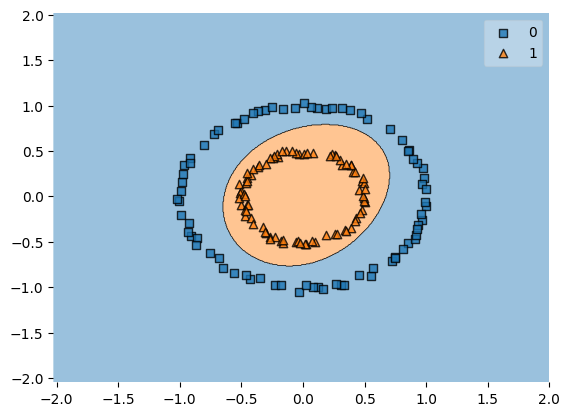

In [12]:
#| code-fold: false
plot_decision_regions(X_train, y_train, clf = KLR)

As you can see, kernel logistic regression is able to learn a non-linear decision boundary that separates the data almost perfectly.